# Density vs density-contrast

## import packages

In [19]:
%load_ext autoreload
%autoreload 2
%load_ext snakeviz

import sys

# local python scripts
from RIS_gravity_inversion import plotting, synthetic
import RIS_gravity_inversion.inversion as inv
import RIS_gravity_inversion.utils as inv_utils

from antarctic_plots import utils, regions, maps, fetch, profile
import numpy as np
import pandas as pd
import xarray as xr
import verde as vd
import scipy as sp
import rioxarray
import harmonica as hm
import pygmt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The snakeviz extension is already loaded. To reload it, use:
  %reload_ext snakeviz


<img src="../figures/absolute_vs_density_contrast_reference.svg" width="1000"/>

## Get sample data

In [20]:
# bedmap 2 data

spacing = 10e3

inner_region = [-250e3, 250e3, -1200e3, -700e3]

buffer_region = utils.alter_region(inner_region, buffer=150e3)[1]

surface = fetch.bedmap2(layer="surface", region=buffer_region, spacing=spacing)
icebase = fetch.bedmap2(layer="icebase", region=buffer_region, spacing=spacing)
bed = fetch.bedmap2(layer="bed", region=buffer_region, spacing=spacing)

# fill nans
surface = surface.fillna(0)
icebase = icebase.fillna(0)

print("surface info: ", utils.get_grid_info(surface))
print("icebase info: ", utils.get_grid_info(icebase))
print("bed info: ", utils.get_grid_info(bed))

spacing larger than original, filtering and resampling


grdsample [WARNING]: Output sampling interval in x exceeds input interval and may lead to aliasing.
grdsample [WARNING]: Output sampling interval in y exceeds input interval and may lead to aliasing.


spacing larger than original, filtering and resampling


grdsample [WARNING]: Output sampling interval in x exceeds input interval and may lead to aliasing.
grdsample [WARNING]: Output sampling interval in y exceeds input interval and may lead to aliasing.


spacing larger than original, filtering and resampling


grdsample [WARNING]: Output sampling interval in x exceeds input interval and may lead to aliasing.
grdsample [WARNING]: Output sampling interval in y exceeds input interval and may lead to aliasing.


surface info:  (10000.0, [-400000.0, 400000.0, -1350000.0, -550000.0], 0.0, 3457.82250977, 'g')
icebase info:  (10000.0, [-400000.0, 400000.0, -1350000.0, -550000.0], -2444.4987793, 3185.74243164, 'g')
bed info:  (10000.0, [-400000.0, 400000.0, -1350000.0, -550000.0], -2444.4987793, 3185.74243164, 'g')


returning original grid
returning original grid
returning original grid


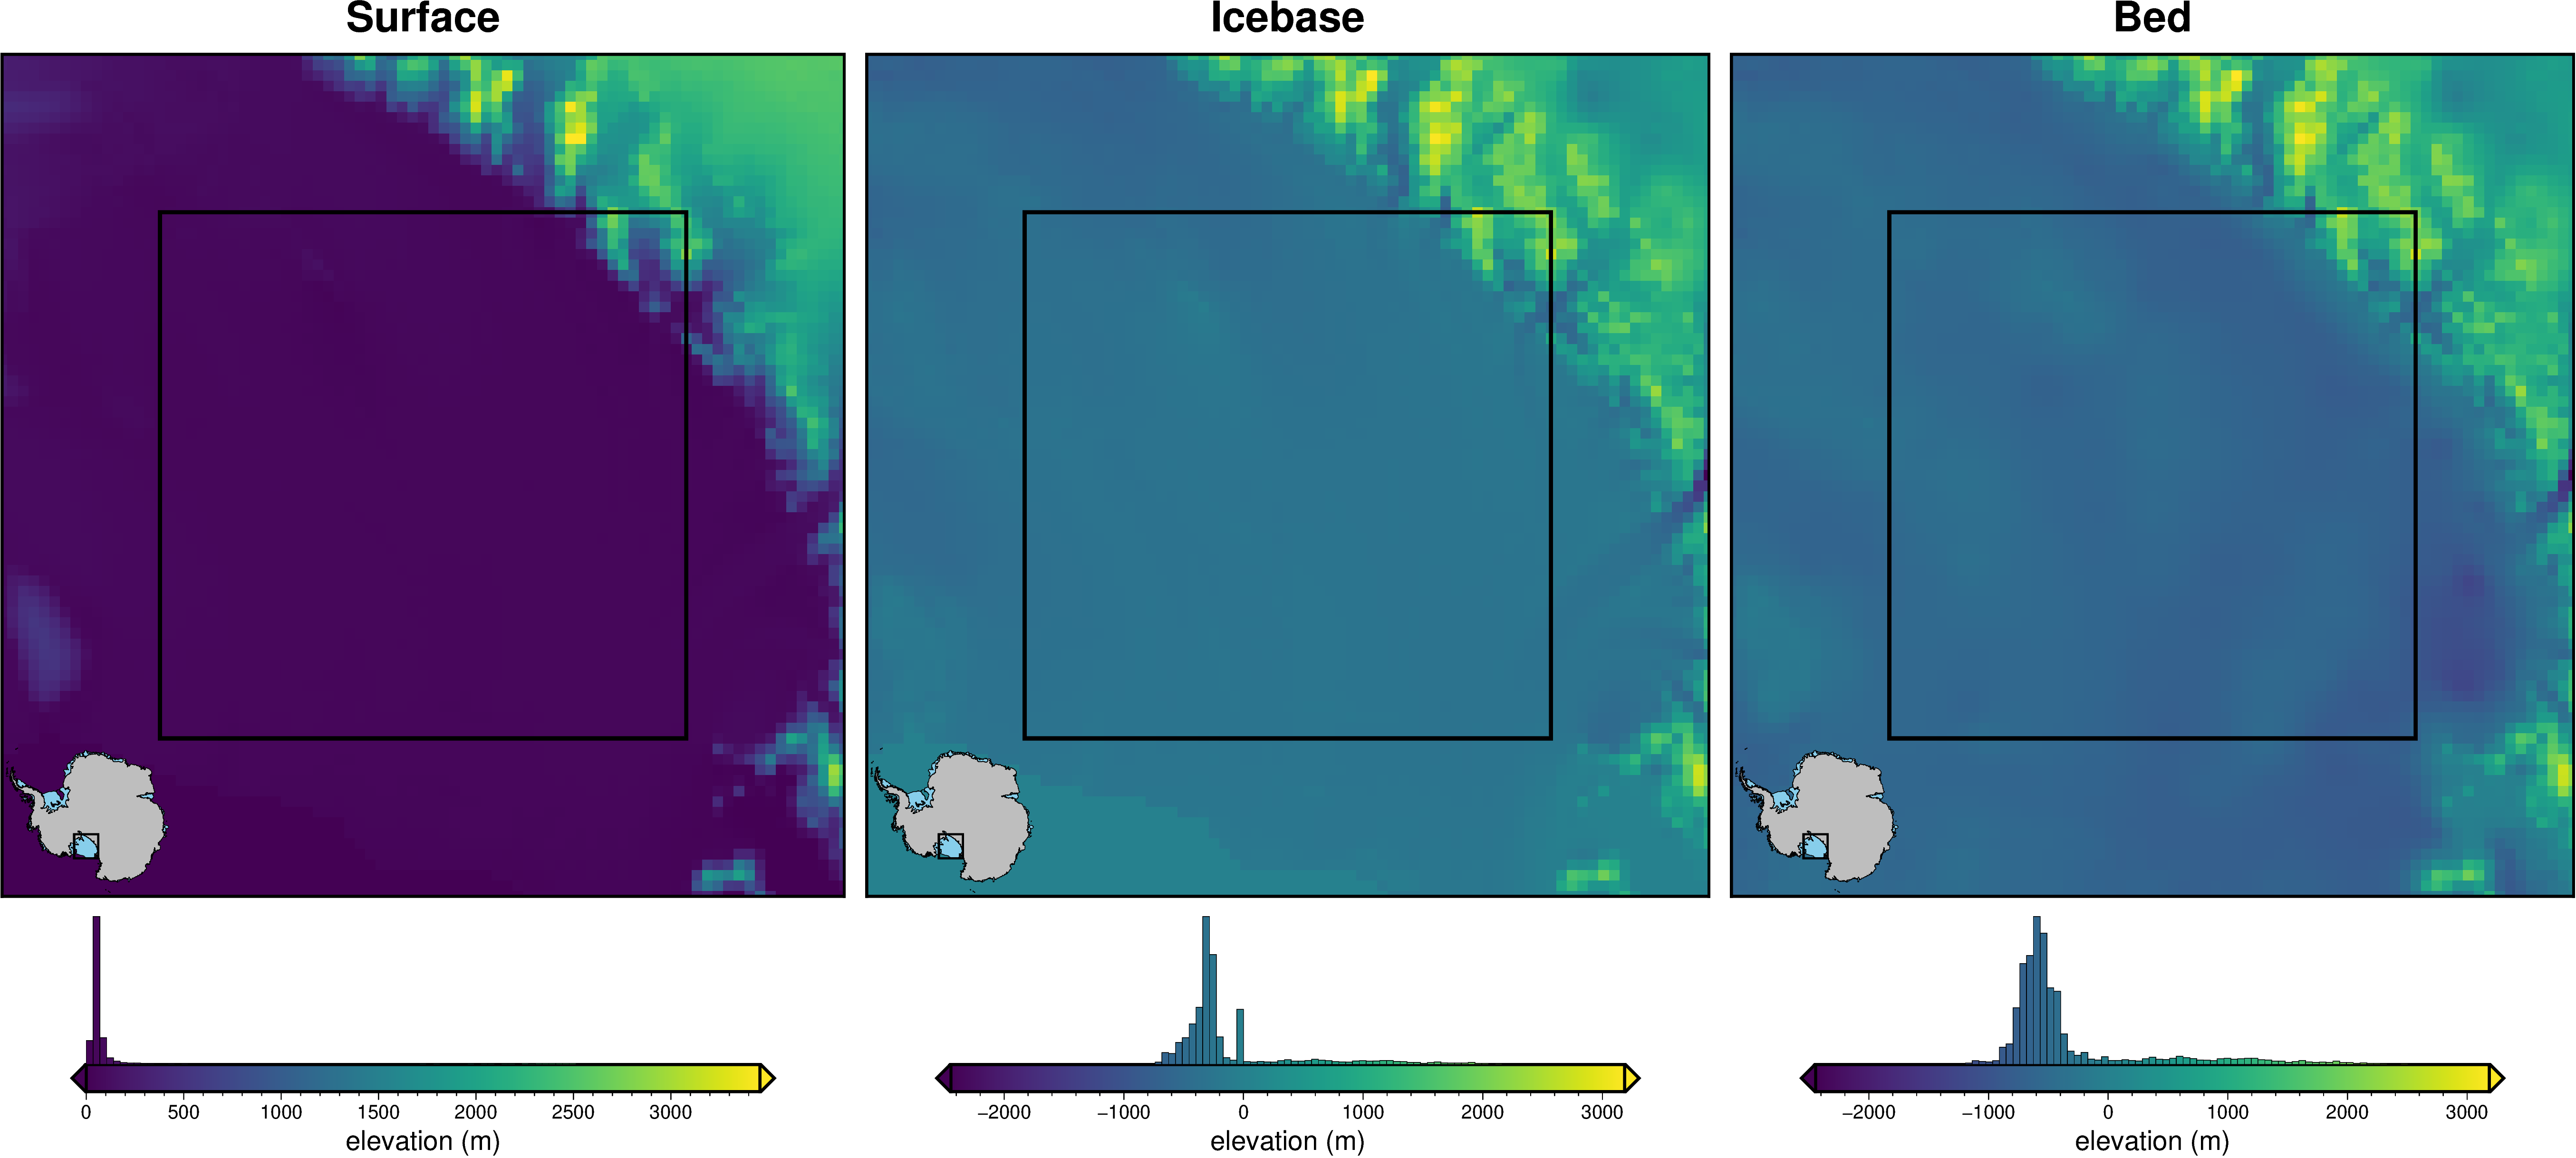

In [21]:
fig = maps.plot_grd(
    surface,
    inset=True,
    title="Surface",
    cbar_label="elevation (m)",
    show_region=inner_region,
    hist=True,
)

fig = maps.plot_grd(
    icebase,
    inset=True,
    title="Icebase",
    cbar_label="elevation (m)",
    show_region=inner_region,
    hist=True,
    fig=fig,
    origin_shift="xshift",
)

fig = maps.plot_grd(
    bed,
    inset=True,
    title="Bed",
    cbar_label="elevation (m)",
    show_region=inner_region,
    hist=True,
    fig=fig,
    origin_shift="xshift",
)
fig.show()

## create observation points

In [23]:
coords = vd.grid_coordinates(
    inner_region,
    spacing=spacing,
    extra_coords=4e3,
)

# grid the coordinates
observations = vd.make_xarray_grid(
    (coords[0], coords[1]),
    data=coords[2],
    data_names="z",
    dims=("y", "x"),
).z

observation_points = vd.grid_to_table(observations)

## Absolute Densities

In [25]:
ice_prisms = inv_utils.grids_to_prisms(
    surface,
    icebase,
    density=917,
)

water_prisms = inv_utils.grids_to_prisms(
    icebase,
    bed,
    density=1030,
)

bed_prisms = inv_utils.grids_to_prisms(
    bed,
    bed.values.min(),
    density=2670,
)

plotting.show_prism_layers(
    [
        ice_prisms,
        water_prisms,
        bed_prisms,
    ],
    cmap="viridis",
    # color_by="density",
    # color_by="thickness",
    color_by="constant",
    clip_box=False,
    zscale=20,
)

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

  0%|          | 0/2601 [00:00<?, ?it/s]

  0%|          | 0/2601 [00:00<?, ?it/s]

  0%|          | 0/2601 [00:00<?, ?it/s]

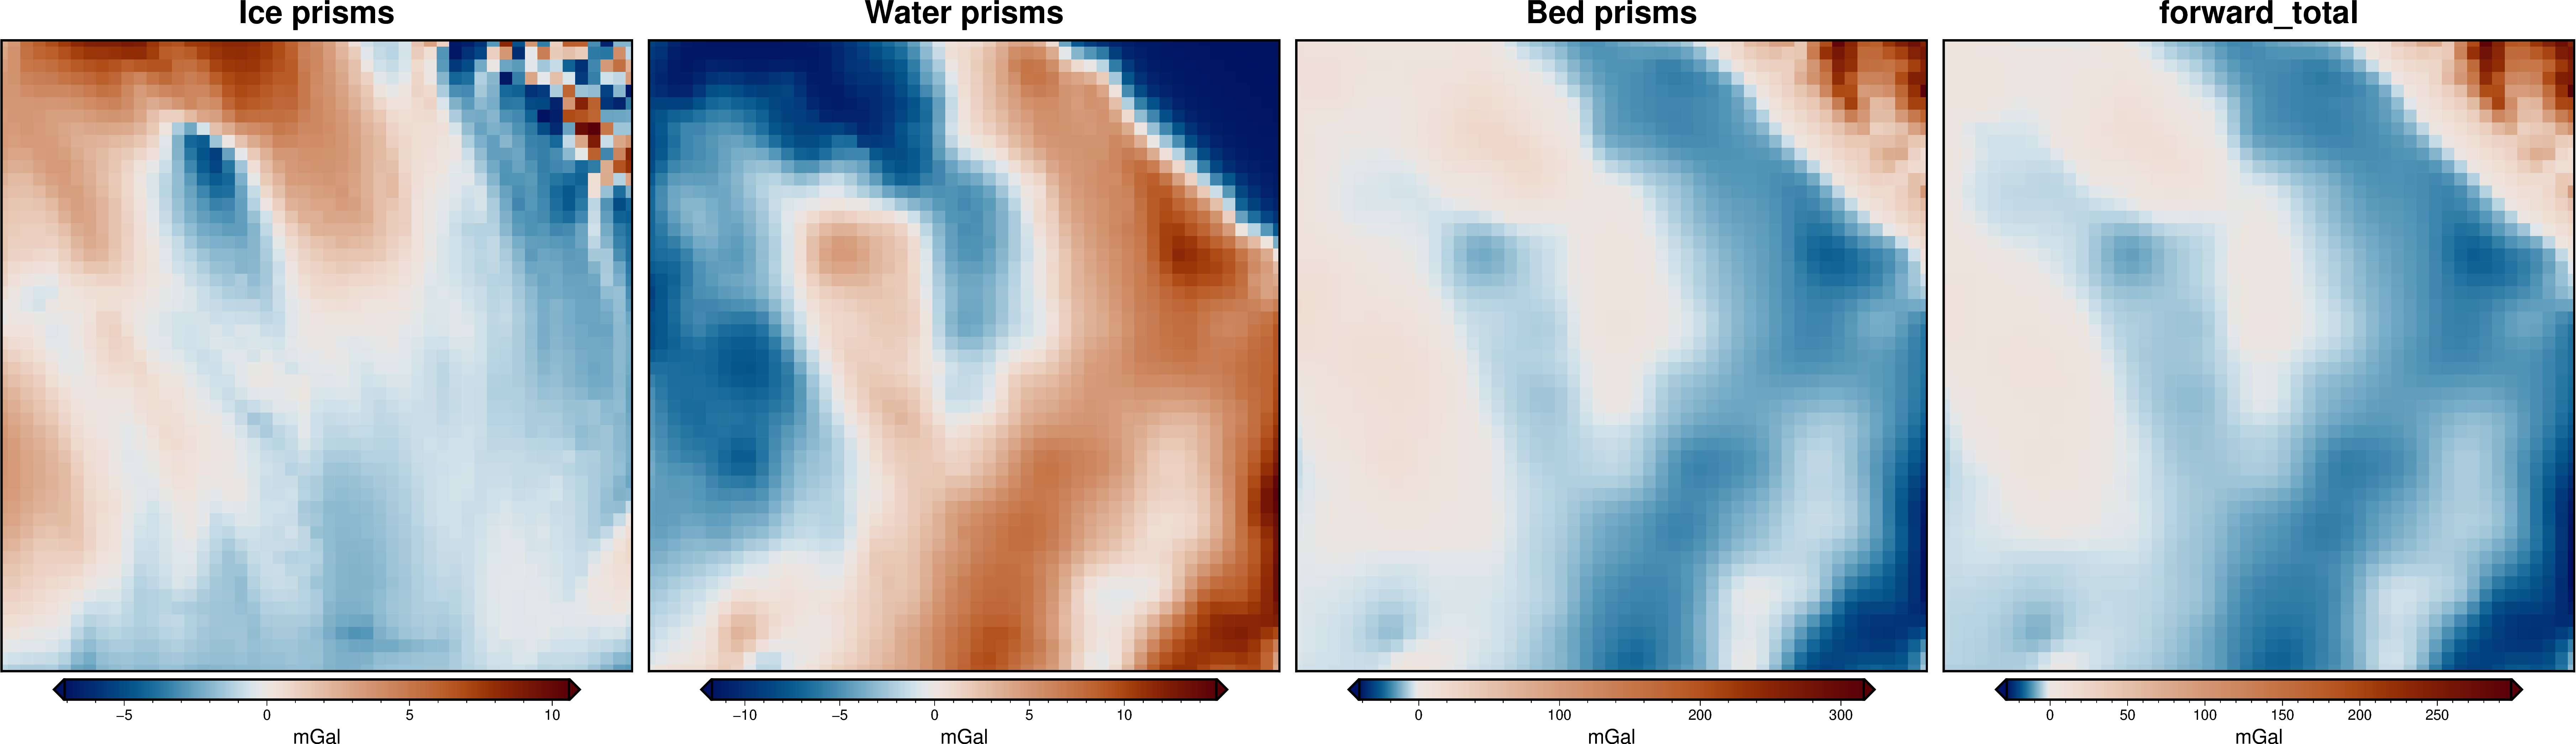

In [26]:
forward_absolute, df = inv_utils.forward_grav_of_prismlayer(
    [ice_prisms, water_prisms, bed_prisms],
    observation_points,
    plot=True,
    names=["Ice prisms", "Water prisms", "Bed prisms"],
    remove_mean=True,
    progressbar=True,
)

gmtset [WARNING]: Representation of font type not recognized. Using default.


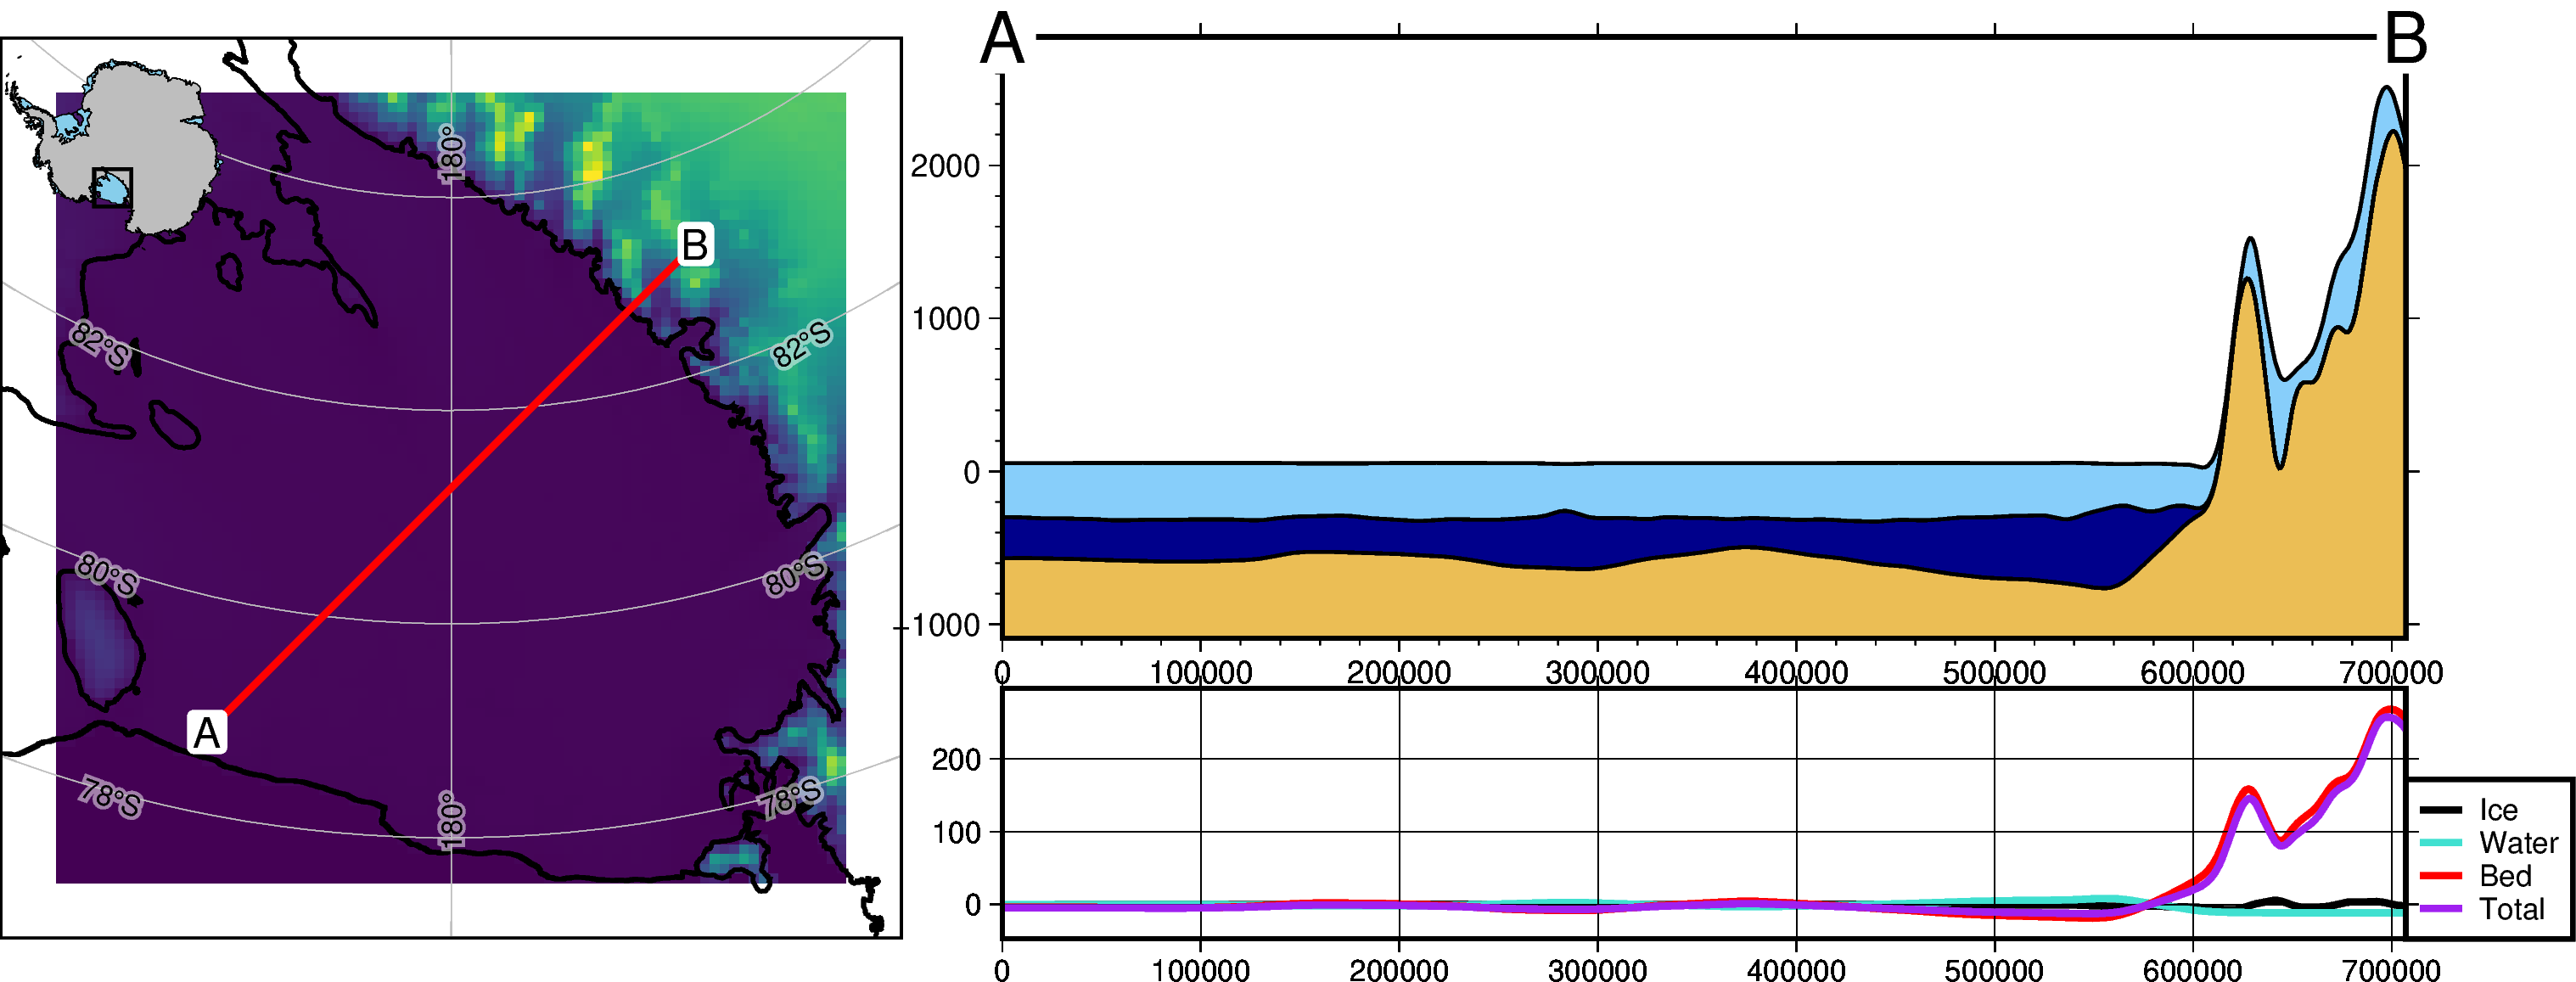

In [36]:
layers_dict = profile.make_data_dict(
    names=["surface", "icebase", "bed"],
    grids=[surface, icebase, bed],
    colors=["lightskyblue", "darkblue", "lightbrown"],
)

data_dict = profile.make_data_dict(
    names=["Ice", "Water", "Bed", "Total"],
    grids=[
        forward_absolute["Ice prisms"],
        forward_absolute["Water prisms"],
        forward_absolute["Bed prisms"],
        forward_absolute["forward_total"],
    ],
    colors=["black", "turquoise", "red", "purple"],
)

profile.plot_profile(
    "points",
    start=(inner_region[0], inner_region[2]),
    stop=(inner_region[1], inner_region[3]),
    num=1000,
    add_map=True,
    subplot_orientation="horizontal",
    # subplot_orientation='vertical',
    layers_dict=layers_dict,
    data_dict=data_dict,
    share_yaxis=True,
    map_background=surface,
    map_cmap="viridis",
)

## Above/below reference

In [28]:
# air-ice
density_contrast = 917 - 0
grid = surface

zref = grid.values.mean()
density = xr.where(grid >= zref, density_contrast, -density_contrast)

zref_surface_prisms = inv_utils.grids_to_prisms(
    grid,
    zref,
    density=density,
)

# ice-water
density_contrast = 1030 - 917
grid = icebase

zref = grid.values.mean()
density = xr.where(grid >= zref, density_contrast, -density_contrast)

zref_icebase_prisms = inv_utils.grids_to_prisms(
    grid,
    zref,
    density=density,
)

# water-bed
density_contrast = 2670 - 1030
grid = bed

zref = grid.values.mean()
density = xr.where(grid >= zref, density_contrast, -density_contrast)

zref_bed_prisms = inv_utils.grids_to_prisms(
    grid,
    zref,
    density=density,
)

plotting.show_prism_layers(
    [
        zref_surface_prisms,
        zref_icebase_prisms,
        zref_bed_prisms,
    ],
    cmap="viridis",
    color_by="density",
    # color_by="thickness",
    # color_by='constant',
    log_scale=False,
    clip_box=False,
    zscale=20,
)

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

  0%|          | 0/2601 [00:00<?, ?it/s]

  0%|          | 0/2601 [00:00<?, ?it/s]

  0%|          | 0/2601 [00:00<?, ?it/s]

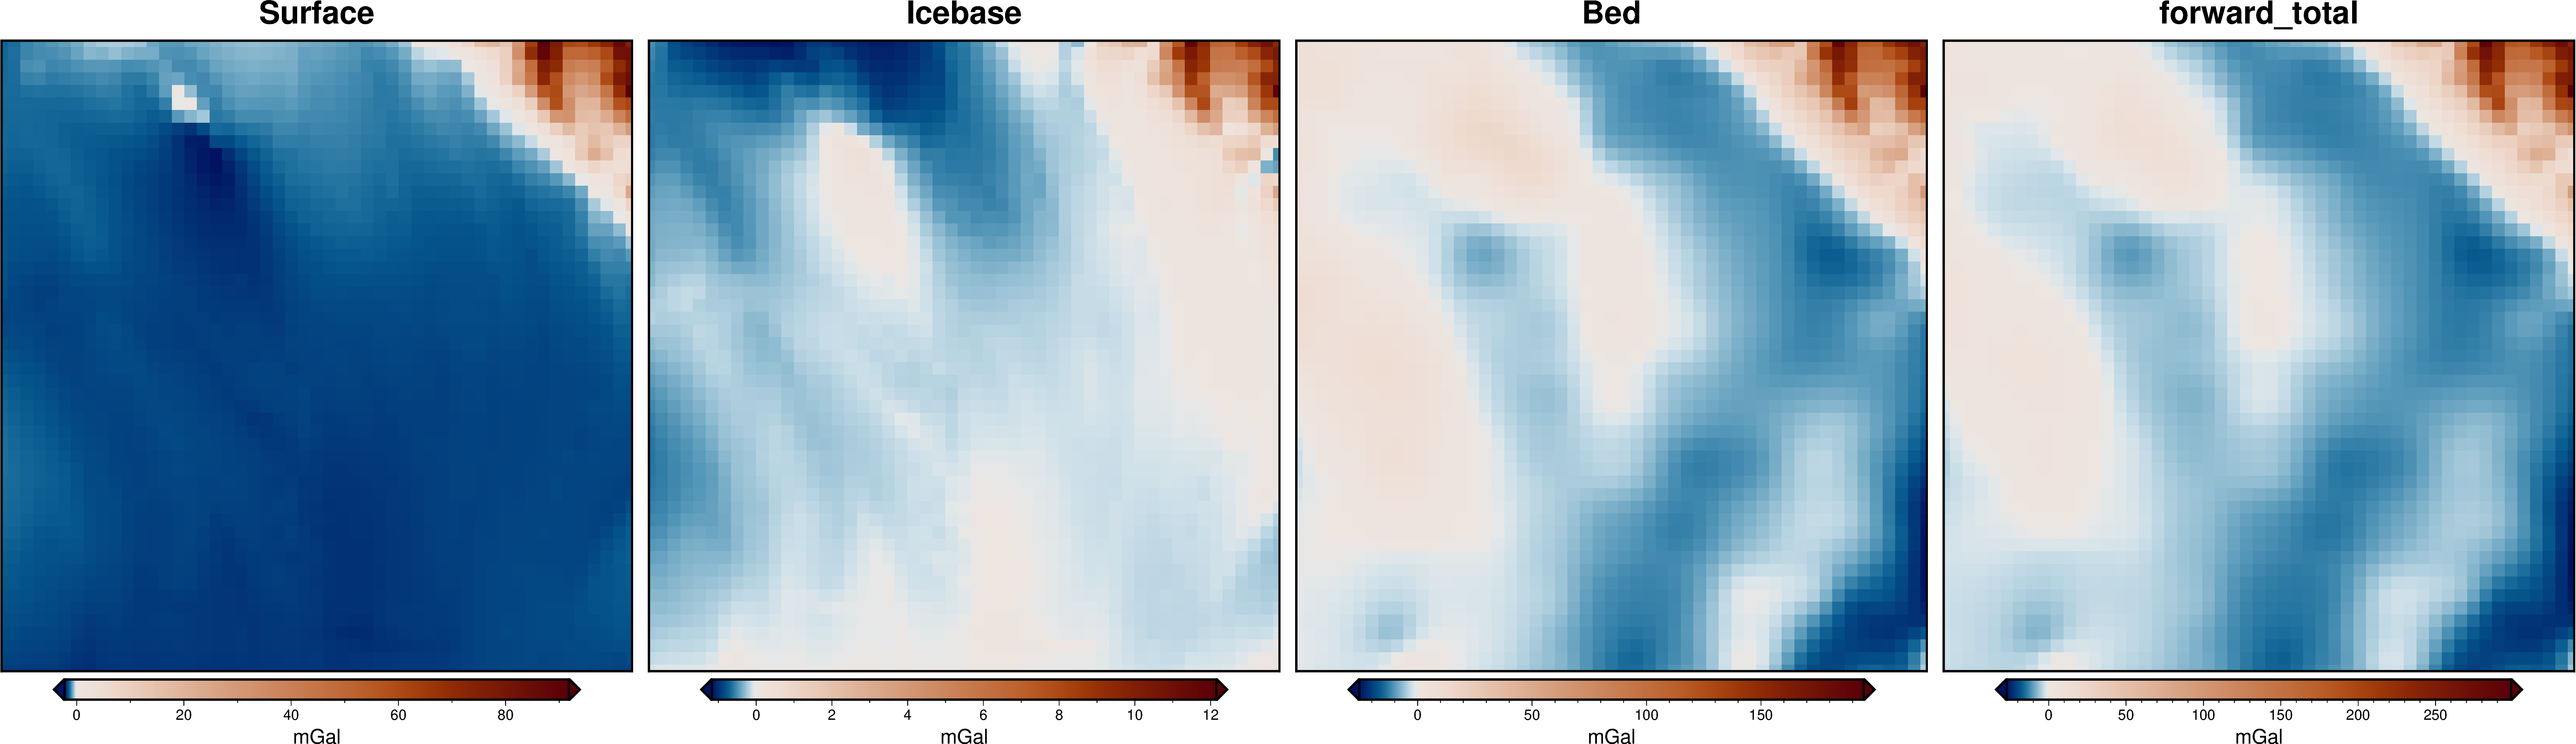

In [29]:
zref_grav, df = inv_utils.forward_grav_of_prismlayer(
    [
        zref_surface_prisms,
        zref_icebase_prisms,
        zref_bed_prisms,
    ],
    observation_points,
    plot=True,
    names=["Surface", "Icebase", "Bed"],
    remove_mean=True,
    progressbar=True,
)

gmtset [WARNING]: Representation of font type not recognized. Using default.


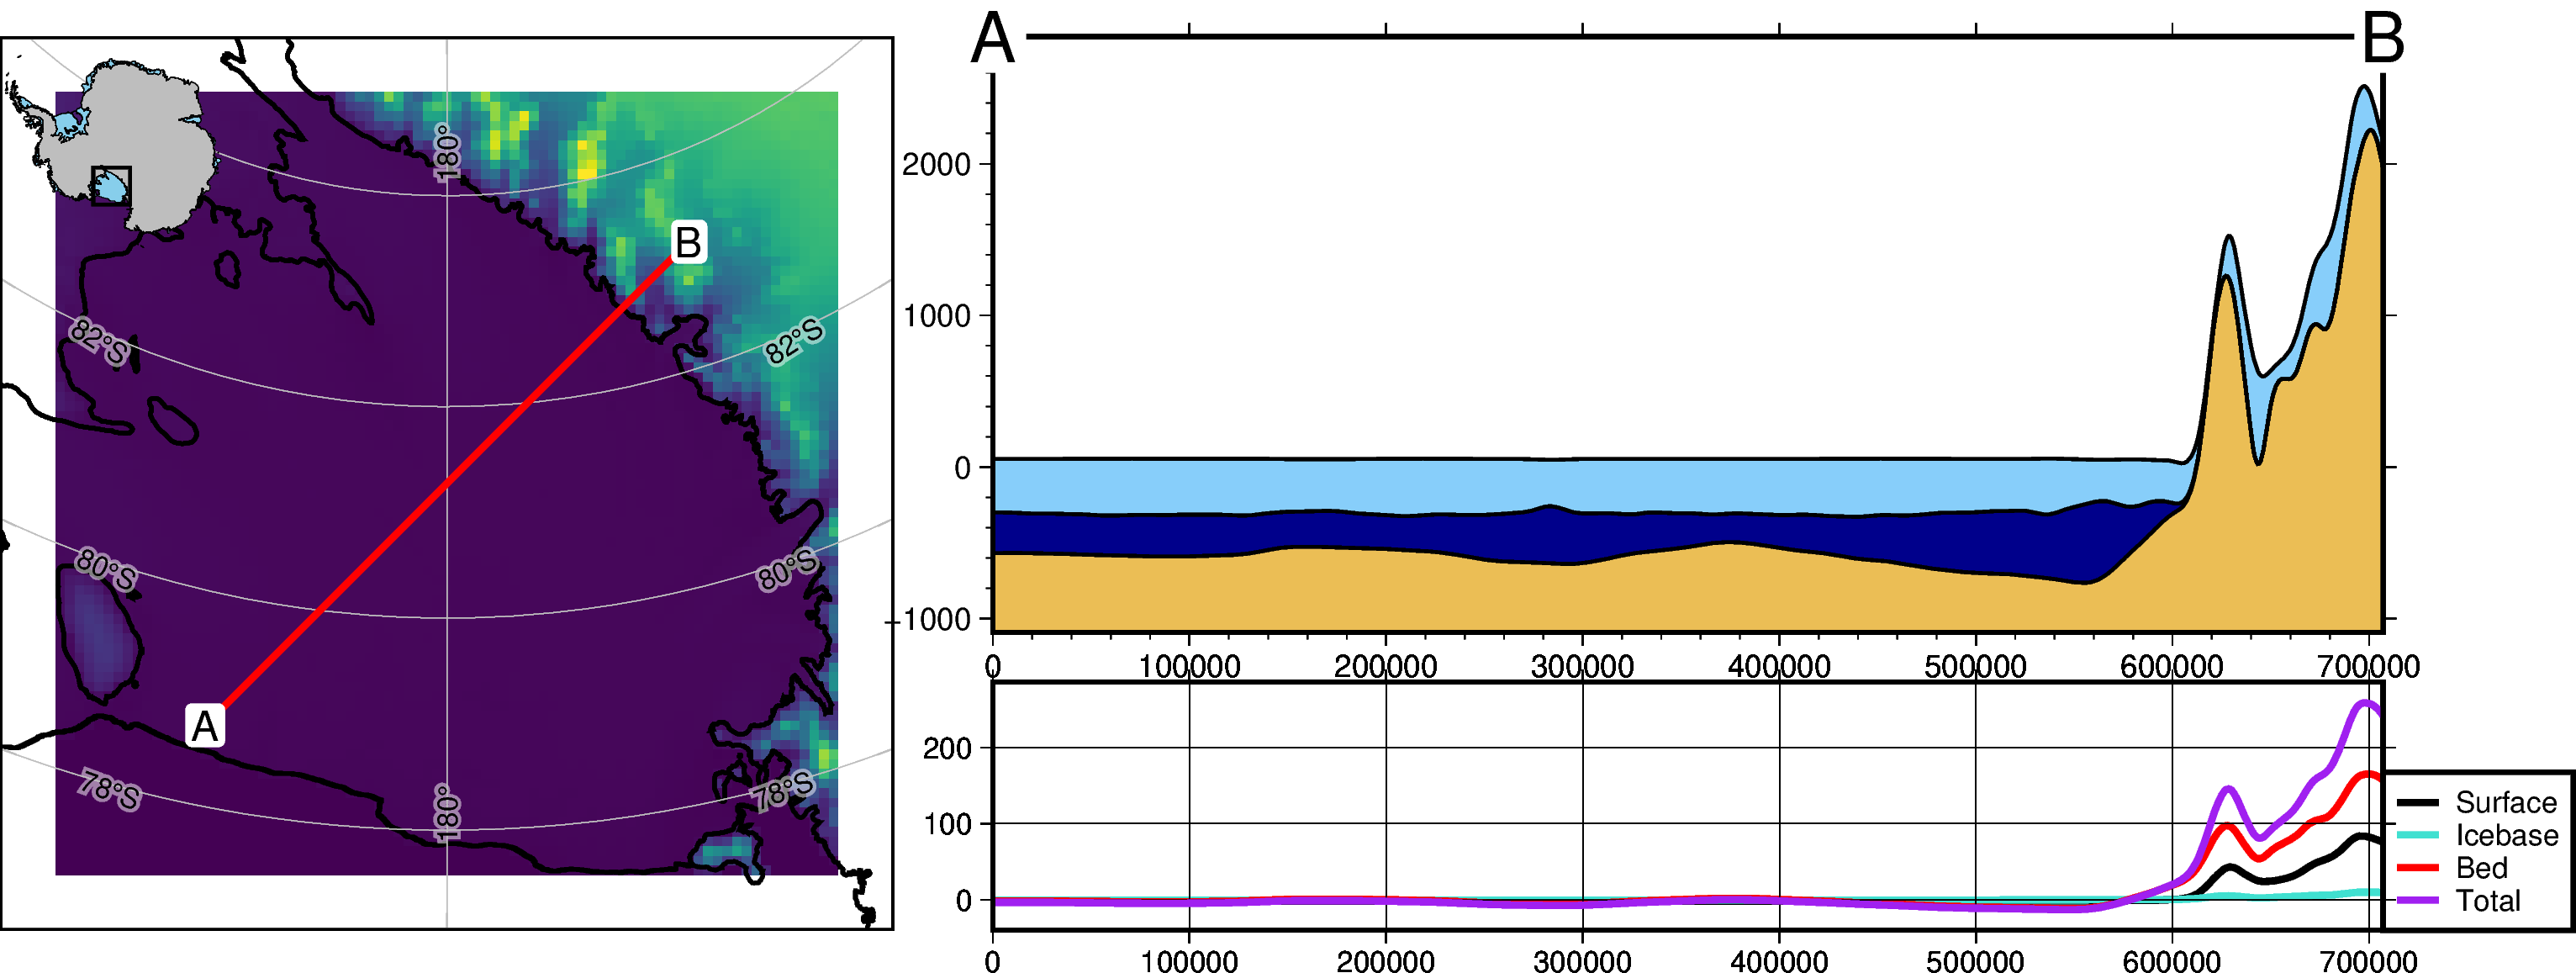

In [32]:
layers_dict = profile.make_data_dict(
    names=["surface", "icebase", "bed"],
    grids=[surface, icebase, bed],
    colors=["lightskyblue", "darkblue", "lightbrown"],
)

data_dict = profile.make_data_dict(
    names=["Surface", "Icebase", "Bed", "Total"],
    grids=[
        zref_grav.Surface,
        zref_grav.Icebase,
        zref_grav.Bed,
        zref_grav.forward_total,
    ],
    colors=["black", "turquoise", "red", "purple"],
)

profile.plot_profile(
    "points",
    start=(inner_region[0], inner_region[2]),
    stop=(inner_region[1], inner_region[3]),
    num=1000,
    add_map=True,
    subplot_orientation="horizontal",
    # subplot_orientation='vertical',
    layers_dict=layers_dict,
    data_dict=data_dict,
    share_yaxis=True,
    map_background=surface,
    map_cmap="viridis",
)

## Compare forward gravities

In [37]:
plot_type = "xarray"
# plot_type = 'pygmt'

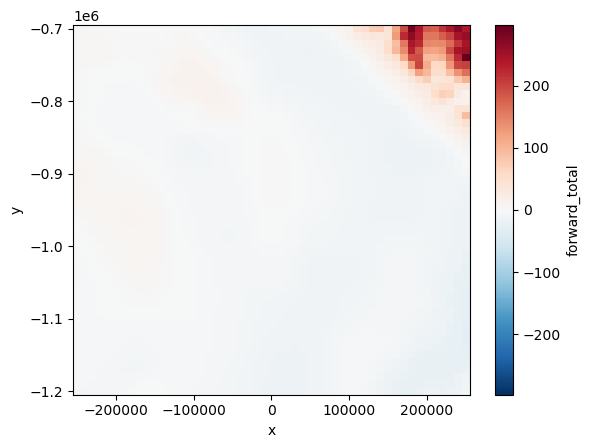

In [42]:
forward_absolute.forward_total.plot()

returning original grid
returning original grid


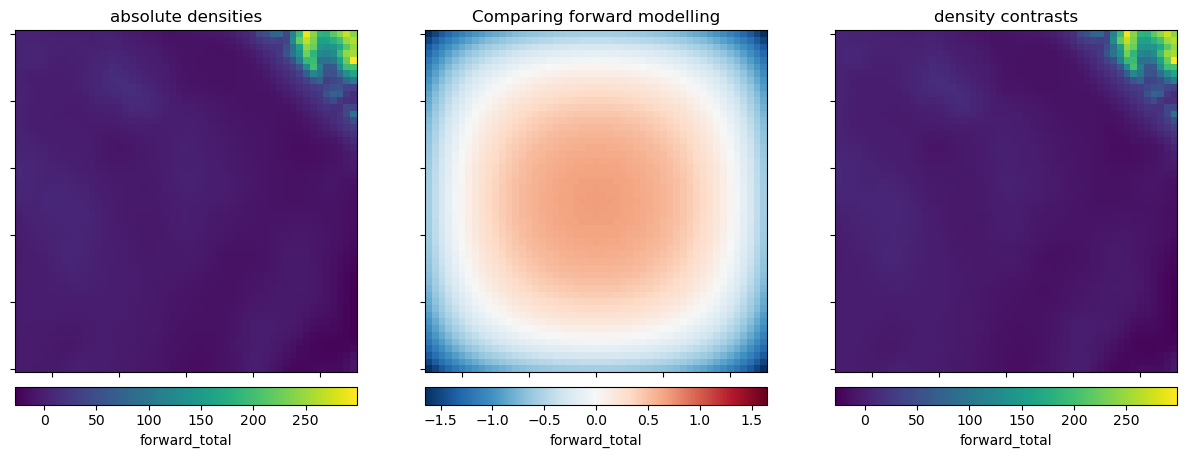

In [45]:
# absolute = forward_absolute[-1] - forward_absolute[-1].mean()
# zref = zref_grav[-1] - zref_grav[-1].mean()

grids = utils.grd_compare(
    forward_absolute.forward_total,
    zref_grav.forward_total,
    plot=True,
    grid1_name="absolute densities",
    grid2_name="density contrasts",
    title="Comparing forward modelling",
    # diff_maxabs=50,
    hist=True,
    plot_type=plot_type,
)

Note, while the difference between the forward gravity calculation with absolute densities vs density contrasts is small, it is not uniform. The calculate with absolute values is higher in the center, and smaller on the edges. This seems to be due to a large edge effect when using absolue densities. 

When using the Zref and density contrast, the average prism height is approximately half compared to with absolue densities, since the prisms reference is the mean of the surface, and not the minimum.